In [55]:
import numpy as np
from scipy import stats
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from functools import reduce

# Generalization of MacArthur's Consumer Resource Model (**CRM**)

In this notebook we will focus on the Consumer Resource Model with multiple species and resources and characterized by the following equations:

$$
\begin{cases}
\dot{n}_{\sigma} \quad = \quad n_{\sigma} \cdot \left ( \sum\limits_{i = 1}^{p} v_i \alpha_{\sigma i} r_i(c_i)  - \delta_{\sigma} \right ); \quad \quad \quad \sigma = 1, \dots, m

\\
\\

\dot{c}_i \quad = \quad s_i -  \sum\limits_{\sigma = 1}^{m} n_{\sigma} \alpha_{\sigma i} r_i(c_i); \quad \quad \quad i = 1, \dots, p

\end{cases}
$$

$s_i$ is the supply rate, i.e. the rate of growth of the $i_{th}$ resource. $\alpha_{\sigma i}$ is the metabolic energy of species σ devoted to eat resource $i$, also called the metabolic strategy of $\sigma$. In particular, only if  $\alpha_{\sigma i} > 0$ species $\sigma$ can consume resource $i$. <br>
In this application we use, for the supply rate, the analytical form $s_i \left (  c_i  \right ) = \omega_i c_i \cdot \left (  1 - \dfrac{c_i}{k_i} \right )$ and also we consider $r(c_i) = c_i$ (Biotic resources).

<br/>

As a starting point we will consider $S = 5$ species and $R = 5$ resources. We will assign the the metabolic strategies at random from a unifrom distribution asssuming values in $\left [ 0, 0.2 \right ]$ and we will set all the other parameters to $1$ while death rate will be set to a low value equal for all the species.

<br/>

The task carred on in this notebook are summarized in the following:

- **Task 1**: Perform the simulations of the full **CRM** model and compare the stationary solution you find numerically with those obtained analytically.

<br/>

- **Task 2**: Set $\omega = 10$ and do the simulation of the quasi stationary approximation (**QSA**) and compare it with the simulations of the full **CRM** (keeping fixed the metabolic strategies in the two cases for a given realization). Do several (e.g. $>20$) realizations of the dynamics to obtain a statistics of the species population stationary states in the two cases, represent each population through a Box-Whisker Plot both for the full **CRM** and the **GLV** and compare the two.

<br/>

- **Task 3**: Verify if the quasi-stationary approximation does work if $\omega = 0.1$? Why?


## Stationary solution 

To find the stationary solution we put both terms of the system equal to zero. We start from the first and we do not treat the non trivial solution ($n_{\sigma} = 0$),

$$

\sum\limits_{i = 1}^{p} v_i \alpha_{\sigma i} r_i(c^*_i)  - \delta_{\sigma} = 0

$$

That with our choice of parameters becomes,

$$

\sum\limits_{i = 1}^{p} \alpha_{\sigma i} c^*_i  - \delta_{\sigma} = 0

$$

Passing to a vector notation, with $A$ being the matrix of the metabolic strategies in this formalism, we have,

$$

A \cdot \vec{c^*_{i}} - \delta\vec{1}_{\sigma} = 0 

$$

Where $\vec{1}_{\sigma}$ is the column vector of $m$ elements all equal to $1$. <br>
That yelds,

$$

\vec{c^*_{i}} = A^{-1} \cdot \delta\vec{1}_{\sigma}

$$

Let's now consider the second equation,

$$

s_i -  \sum\limits_{\sigma = 1}^{m} n^*_{\sigma} \alpha_{\sigma i} r_i(c^*_i) = 0

$$

That in our case becomes,

$$

\cancel{c^*_i} \cdot (1 - c^*_i) -  \sum\limits_{\sigma = 1}^{m} n^*_{\sigma} \alpha_{\sigma i} \cancel{c^*_i} = 0

$$

Passing to a vector notation and renaming $(1 - c^*_i)$ as $\vec{\mu^*_i}$ we have,

$$

\vec{\mu^*_i}  =  \vec{n^*_{\sigma}} \cdot A; \quad \quad \quad \vec{n^*_{\sigma}} = \vec{\mu^*_i} \cdot A^{-1}

$$


In [4]:
# Setting numpy seed

n_species = 5
n_resources = 5
death_rate = 1/100

In [5]:
np.random.seed(8)
identity = np.eye(n_species, n_resources)
np.random.shuffle(identity)
metabolic_strategies = identity * np.random.uniform(0, 0.2,\
     size = (n_species, n_resources))


death_rate_vec = np.ones(n_species) * death_rate

In [6]:
print('Metabolic startegies:\n')
display(metabolic_strategies)
print('Death rate:\n')
display(death_rate_vec)

Metabolic startegies:



array([[0.        , 0.        , 0.        , 0.        , 0.08609376],
       [0.        , 0.        , 0.09567836, 0.        , 0.        ],
       [0.        , 0.14247491, 0.        , 0.        , 0.        ],
       [0.19477105, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.04495399, 0.        ]])

Death rate:



array([0.01, 0.01, 0.01, 0.01, 0.01])

In [7]:
metabolic_inv = np.linalg.inv(metabolic_strategies)
c_star = metabolic_inv.dot(death_rate_vec)
c_star

array([0.05134233, 0.07018779, 0.10451684, 0.22244968, 0.11615243])

In [8]:
mu_star = np.ones(n_species) - c_star

n_star = mu_star.dot(metabolic_inv)
n_star

array([10.26610443,  9.35930722,  6.52614677,  4.87062978, 17.29658174])

In [9]:
initial_n = list(np.abs(stats.norm.rvs(loc = 5, scale = 1, size=n_species)))
initial_c = list(np.abs(stats.norm.rvs(loc = 5, scale = 1, size=n_resources)))








def system(y, t, n_resources, n_species, a, death_rate, omega):
    return_list = []
    n_vec = np.array(y[:n_species])
    c_vec = np.array(y[n_species:])
    omega_vec = omega * np.ones(n_resources)
    for i in range(n_species):
        n = y[i]
        dn_dt = n * ( np.sum(a[i, :] * c_vec) - death_rate)
        return_list.append(dn_dt)

    for j in range(n_resources):
        
        c = y[n_species + j]
        s_i = omega_vec[j] * c * (1 - c)
        dc_dt = s_i - (np.sum(n_vec * a[:, j] * c))
        return_list.append(dc_dt)
    
    return return_list

    


# time_domain
t = np.linspace(0, 200, 200)

# initial conditions
y0 = initial_n + initial_c

solution = odeint(system, y0, t, args=(n_resources, n_species,\
    metabolic_strategies, death_rate, 1), full_output=0)

# Saving solution
#pd.DataFrame(solution[0], columns = ['n1', 'n2', 'c1', 'c2', 'c3']).to_csv('../../data/week_5/CRM32.csv')

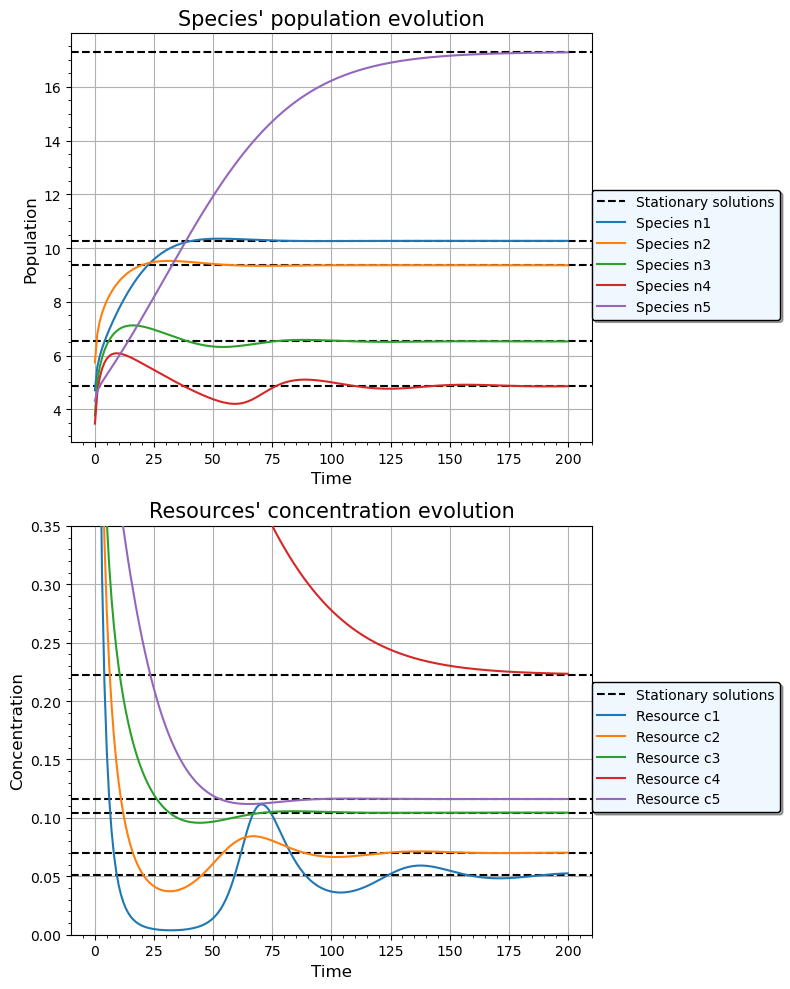

In [10]:
fig, ax_ = plt.subplots(2, 1, figsize=(8, 10))
ax, ax1 = ax_
for i in range(n_species):
    ax.axhline(y = n_star[i], color = 'black', linestyle = '--', label = 'Stationary solutions' if i == 0 else None,\
        zorder = 2)
    ax.plot(t, solution[:, i], label = 'Species n' + str(i+1), zorder = 3)
    ax.set_xlabel('Time', fontsize = 12)
    ax.set_ylabel('Population', fontsize = 12)
    ax.set_title('Species\' population evolution', fontsize = 15)
    

ax.legend(facecolor = 'aliceblue', loc = (1, 0.3), shadow = True, edgecolor = 'black')

for i in range(n_resources):
    ax1.axhline(y = c_star[i], color = 'black', linestyle = '--', label = 'Stationary solutions' if i == 0 else None,\
        zorder = 2)
    ax1.plot(t, solution[:, n_species + i], label = 'Resource c' + str(i+1), zorder = 3)
    ax1.set_xlabel('Time', fontsize = 12)
    ax1.set_ylabel('Concentration', fontsize = 12)
    ax1.set_title('Resources\' concentration evolution', fontsize = 15)
    ax1.set_ylim(0, 0.35)

ax1.legend(facecolor = 'aliceblue', loc = (1, 0.3), shadow = True, edgecolor = 'black')

for a in ax_:
    a.minorticks_on()
    a.grid(zorder = 1)

fig.tight_layout()

## Quasi-stationary approximation

In this $2^{nd}$ section we consider the **Quasi-static approximation**, that is, when the population changes the resource will quickly reach a new equilibrium before the resource can change again. <br>
This can be modeled by taking the approximation $\dot{c_i} = 0$ that will lead to the same solution as above: $c_i = c^*_i$.

<br/>

As far as the population dynamics is concerned, we keep the full equation,

$$

\dot{n}_{\sigma} \quad = \quad n_{\sigma} \cdot \left ( \sum\limits_{i = 1}^{p} \alpha_{\sigma i} c^*_i  - \delta_{\sigma} \right ); \quad \quad \quad \sigma = 1, \dots, m

$$

In this section $\omega$ will be always contant and equal for all resources bu this time we'll set $\omega = 10 \cdot \vec{1}_i$.

As far as the resources's concentration,

$$
0 \quad = \quad \omega \cdot \cancel{c^*_i} \cdot (1 - c^*_i) -  \sum\limits_{\sigma = 1}^{m} n_{\sigma} \alpha_{\sigma i} \cancel{c^*_i};
$$

$$
c^*_i = 1 - \dfrac{1}{\omega}\sum\limits_{\sigma = 1}^{m} n_{\sigma} \alpha_{\sigma i}
$$

Substituting back in the population dynamics we have,

$$
\dot{n}_{\sigma} \quad = \quad n_{\sigma} \cdot \left ( \sum\limits_{i = 1}^{p} \alpha_{\sigma i} \left [ 1 - \dfrac{1}{\omega}\sum\limits_{\sigma = 1}^{m} n_{\sigma} \alpha_{\sigma i} \right ]  - \delta_{\sigma} \right ); \quad \quad \quad \sigma = 1, \dots, m
$$

In [11]:
t = np.linspace(0, 300, 300)
def system_qsa(y, t, n_resources, a, death_rate, omega):
    return_list = []
    n_vec = np.array(y)
    omega_vec = omega * np.ones(n_resources)
    for i in range(n_species):
        n = y[i]
        dn_dt = n * ( np.sum(a[i, :] * (1 - (1 / omega_vec[i]) * n_vec.dot(a)) ) - death_rate)
        return_list.append(dn_dt)
    
    return return_list

solution_qsa = odeint(system_qsa, initial_n, t, args=(n_resources, metabolic_strategies, death_rate, 10), full_output=0)

In [40]:
resources_qsa = 1 - 1/10 * np.array(solution_qsa[::np.newaxis]).dot(metabolic_strategies)

In [17]:
solution_full = odeint(system, y0, t, args=(n_species, n_resources, metabolic_strategies, death_rate, 10), full_output=0)

In [ ]:
colors = ['khaki', 'mediumorchid', 'navy', 'firebrick', 'forestgreen']

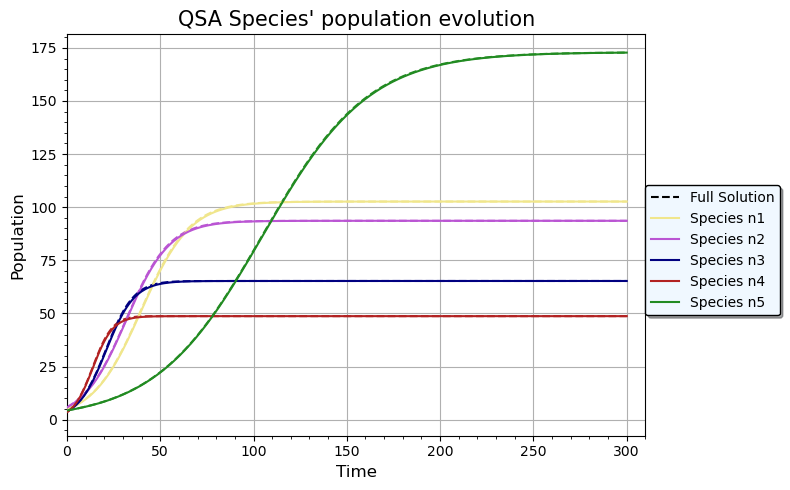

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i in range(n_species):
    ax.plot(400, 1, color = 'black', linestyle = '--', label = 'Full Solution' if i == 0 else None)
    ax.plot(t, solution_qsa[:, i], label = 'Species n' + str(i+1), zorder = 3, color = colors[i])
    ax.plot(t, solution_full[:, i], zorder = 2, linestyle = '--', color = colors[i])
    ax.set_xlabel('Time', fontsize = 12)
    ax.set_ylabel('Population', fontsize = 12)
    ax.set_title('QSA Species\' population evolution', fontsize = 15)
    
    
    
ax.set_xlim(0, 310)
ax.legend(facecolor = 'aliceblue', loc = (1, 0.3), shadow = True, edgecolor = 'black')
#ax.set_ylim(0, 20)

ax.minorticks_on()
ax.grid(zorder = 1)

fig.tight_layout()

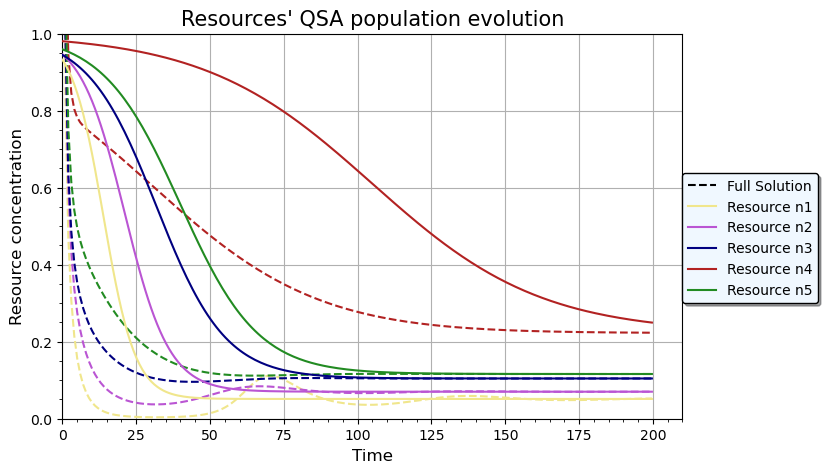

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i in range(n_species):
    ax.plot(400, 1, color = 'black', linestyle = '--', label = 'Full Solution' if i == 0 else None)
    ax.plot(t[:200], resources_qsa[:, i][:200], label = 'Resource n' + str(i+1), zorder = 3, color = colors[i])
    ax.plot(t[:200], solution[:, n_species + i], zorder = 2, linestyle = '--', color = colors[i])
    ax.set_xlabel('Time', fontsize = 12)
    ax.set_ylabel('Resource concentration', fontsize = 12)
    ax.set_title('Resources\' QSA population evolution', fontsize = 15)


    
ax.legend(facecolor = 'aliceblue', loc = (1, 0.3), shadow = True, edgecolor = 'black')
ax.set_ylim(0, 1)
ax.set_xlim(0, 210)
ax.minorticks_on()
ax.grid(zorder = 1)
plt.show()

In [53]:
metabolics = [identity * np.random.uniform(0, 0.2,\
     size = (n_species, n_resources)) for _ in range(1000)]
statistics_qsa = [np.array(odeint(system_qsa, initial_n, t, args=(n_resources, metabolic, death_rate, 10),\
     full_output=0))[-1,:] for metabolic in metabolics]

In [62]:
statistics_species = reduce(lambda x, y: np.vstack([x, y]), statistics_qsa) 

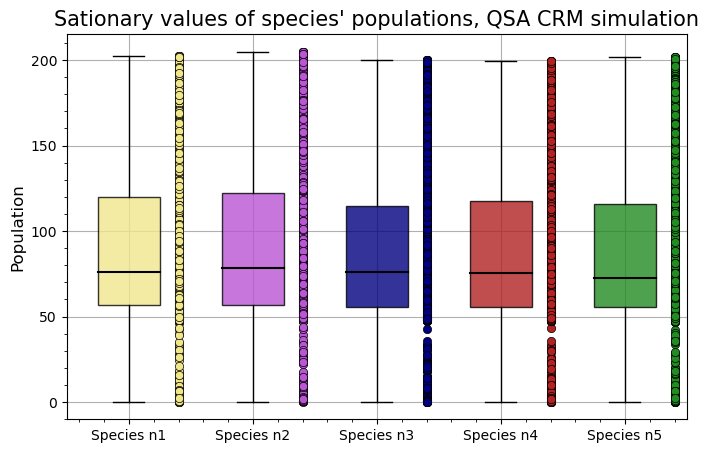

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
bp = ax.boxplot(statistics_species, labels = ['Species n' + str(i+1) for i in range(n_species)], patch_artist=True,\
    medianprops = dict(color="black",linewidth=1.5), showfliers = True)

for i, patch in enumerate(bp['boxes']):
        patch.set(facecolor=colors[i], alpha=0.8, zorder=2)
        ax.scatter(x = (i + 1.4) * np.ones(statistics_species.shape[0]), y = statistics_species[:, i], color = colors[i], zorder=3,\
            edgecolor = 'black', linewidths=0.5)

ax.minorticks_on()
ax.set_title('Sationary values of species\' populations, QSA CRM simulation', fontsize = 15)
ax.set_ylabel('Population', fontsize = 12)
ax.grid(zorder = 1)
plt.show()